In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version= 1)
X, y = mnist['data'], mnist['target']
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X.shape, y.shape

((70000, 784), (70000,))

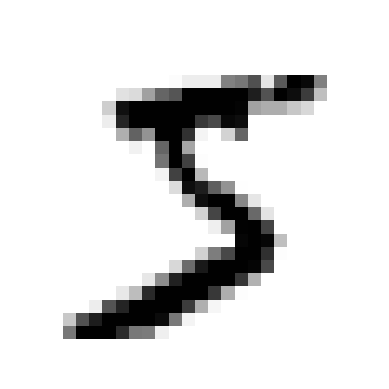

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
some_digit = X.iloc[0].values
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off") # 关闭坐标轴，让图像更清晰
plt.show()

In [4]:
y.iloc[0]

'5'

In [5]:
import numpy as np
y = y.astype(np.uint8)

In [6]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# 训练一个二分类器

## 先训练一个识别单独数字的model


In [7]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

### 使用随机梯度下降

In [8]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state= 42)
sgd_clf.fit(X_train, y_train_5)
sgd_clf.predict([some_digit])

C:\Users\Administrator\anaconda3\envs\DeepLearning-py310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

# 性能评估

## 使用交叉验证测量准确率

### 手动实现K折交叉验证

In [9]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits= 3, random_state= 42, shuffle= True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_folds = X_train[test_index]
    y_test_folds = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = sum(y_pred == y_test_folds) # 计算预测正确的数量
    print(n_correct / len(y_pred))

KeyError: "None of [Index([    1,     3,     4,     5,     7,     8,    10,    11,    12,    13,\n       ...\n       59984, 59985, 59987, 59988, 59989, 59991, 59993, 59994, 59996, 59998],\n      dtype='int32', length=40000)] are in the [columns]"

## 使用scikit-learn的`cross_val_predict`函数

In [10]:
from sklearn.model_selection import cross_val_predict
cross_val_predict(sgd_clf, X_train, y_train_5, cv= 3)

array([ True, False, False, ...,  True, False, False])

# 创建一个base分类器
## 这个简单单分类器的准确率也有90 说明对于分类器来讲 准确率不能成为一个很好的指标

In [11]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X),), dtype=bool)

In [14]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv= 3, scoring= "accuracy")

TypeError: got an unexpected keyword argument 'scoring'

# 计算混淆矩阵

In [15]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv= 3)  # 这个函数返回预测的结果

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [16]:
# 一个完美的混淆矩阵
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

In [18]:
# 或者可以计算精度或者召回率 公式为 TP / (TP + FP) 和 TP / (TP + FN)
from sklearn.metrics import precision_score, recall_score

print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))

0.8370879772350012
0.6511713705958311


# 将precision score和recall score结合起来 得到F1score 公式为 2 * (precision * recall) / (precision + recall)

### 只有当两个分数都比较高的时候f1分数才会高一点

In [19]:
from sklearn.metrics import f1_score
print(f1_score(y_train_5, y_train_pred))

0.7325171197343847


# 精度/ 召回率权衡